# STrEAM Model

In [ ]:
# In a single cell, before importing anything:
!pip install --upgrade --force-reinstall \
    numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.3.2 \
    torch==2.6.0 torchvision==0.21.0


Necessary Libraries

In [ ]:
import pathlib,urllib.request
import pathlib, gdown
import os
import numpy as np, torch
from sklearn.preprocessing import StandardScaler

Fetch Dataset

In [ ]:
if not pathlib.Path('PEMS04.npz').exists():
    print("Downloading PEMS04.npz...")
    # Use gdown to properly handle Google Drive download
    gdown.download(
        id='16zdWLb0J_0jOq2q3-3AQNhNxJFJS3CC1',
        output='PEMS04.npz',
        quiet=False
    )


class PeMS04(torch.utils.data.Dataset):
    def __init__(self, split, win=12, hor=12, mask_ratio=0.1):
        data = np.load('PEMS04.npz')['data'].astype('float32')
        T = len(data); tr,va = int(.6*T), int(.8*T)
        data = data[:tr] if split=='train' else \
               data[tr:va] if split=='val' else data[va:]
        self.scaler = StandardScaler().fit(data.reshape(-1,data.shape[-1]))
        data = self.scaler.transform(data.reshape(-1,data.shape[-1])
                         ).reshape(data.shape).astype('float32')
        self.x,self.y = [],[]
        for t in range(len(data)-win-hor+1):
            self.x.append(data[t:t+win]);  self.y.append(data[t+win:t+win+hor])
        self.x,np_x = np.array(self.x), np.array(self.y)
        self.m = mask_ratio

    def __len__(self): return len(self.x)
    def __getitem__(self,i):
        x,y = self.x[i], self.y[i]
        mask = (np.random.rand(*x.shape[:2])<self.m)
        return (torch.tensor(x),
                torch.tensor(y),
                torch.tensor(mask, dtype=torch.bool))

--- masked pre-training ---
pre 0.006488672432434209
pre -0.057126645676314106
pre -0.09760228802885448
--- fine-tuning ---
ep01  train -1.0220  val -1.2520
ep02  train -1.4439  val -1.4693
ep03  train -1.6182  val -1.5559
ep04  train -1.7209  val -1.6631
ep05  train -1.7834  val -1.6956
ep06  train -1.8442  val -1.6757
ep07  train -1.8692  val -1.6850
ep08  train -1.9103  val -1.7140
ep09  train -1.9350  val -1.7670

== Test ==
MAE 0.271 RMSE 0.613


Text(0.5, 1.0, 'Spatial Attention @ last step')

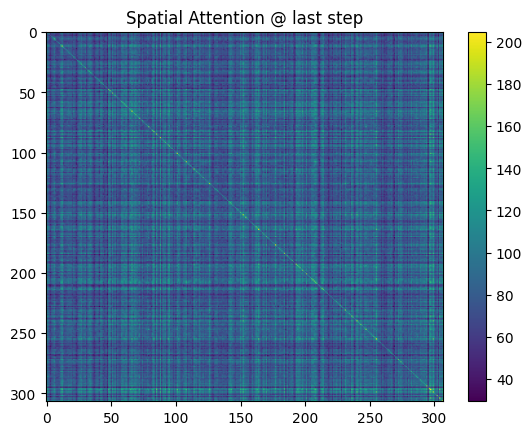

In [ ]:
# Model 
import torch.nn as nn, torch.nn.functional as F

class LinAttn(nn.Module):
    def __init__(self,d,h):
        super().__init__()
        self.h,self.dk = h,d//h
        self.qkv = nn.Linear(d,3*d)
        self.proj= nn.Linear(d,d)
    def phi(self,z): return F.relu(z)+1e-4
    def forward(self,x):                 # x: [B,S,d]
        B,S,d = x.shape
        q,k,v = self.qkv(x).view(B,S,3,self.h,self.dk).unbind(2)
        q,k  = map(self.phi,(q,k))
        kv   = (k*v).sum(1,keepdim=True)
        z    = 1/(q*k.sum(1,keepdim=True)+1e-6)
        o    = (q*kv)*z                 # [B,S,heads,dk]
        o    = o.reshape(B,S,self.h*self.dk)  # flatten -> [B,S,d]
        return self.proj(o)

class Block(nn.Module):
    def __init__(self,d,h):
        super().__init__()
        self.attn = LinAttn(d,h)
        self.ff   = nn.Sequential(nn.Linear(d,4*d),nn.GELU(),nn.Linear(4*d,d))
        self.n1,self.n2 = nn.LayerNorm(d),nn.LayerNorm(d)
    def forward(self,x):
        x = self.n1(x+self.attn(x))
        return self.n2(x+self.ff(x))

class ODEfunc(nn.Module):
    def __init__(self,d):
        super().__init__()
        self.f = nn.Sequential(nn.Linear(d,d),nn.Tanh(),nn.Linear(d,d))
    def forward(self,h):
        return h + self.f(h)

class STrEAM(nn.Module):
    def __init__(self,N,C,d=64,heads=4,layers=4,hor=12):
        super().__init__()
        self.hor  = hor
        self.spa  = nn.Parameter(torch.randn(N,d))
        self.temb = nn.Embedding(288,d)
        self.inp  = nn.Linear(C,d)
        self.enc  = nn.ModuleList(Block(d,heads) for _ in range(layers))
        self.ode  = ODEfunc(d)
        self.out  = nn.Linear(d,2*C*hor)

    def forward(self,x):            # x: [B,T,N,C]
        B,T,N,C = x.shape
        t = torch.arange(T,device=x.device)[None,:].repeat(B,1)
        h = self.inp(x) + self.spa[None,None] + self.temb(t)[...,None,:]
        # make contiguous before flatten:
        h = h.contiguous().view(B*T, N, -1)
        for blk in self.enc:
            h = blk(h)
        h = h.view(B,T,N,-1)[:,-1]
        h = self.ode(h)
        mu,ls = self.out(h).view(B,self.hor,N,C,2).unbind(-1)
        return mu, ls

#  4) Train/Eval Routines 
def nll(mu,logs,y,mask=None):
    inv = (-logs).exp()
    v   = logs + (y-mu).pow(2)*inv
    return (v if mask is None else v*mask[...,None]).mean()

def run_epoch(dl,net,opt=None,pre=False):
    net.train(opt is not None); total=0
    for x,y,mask in dl:
        x,y,mask = x.cuda(),y.cuda(),mask.cuda()
        mu,ls = net(x)
        loss  = nll(mu,ls, x if pre else y, mask if pre else None)
        if opt:
            opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*len(x)
    return total/len(dl.dataset)

@torch.no_grad()
def report(dl,net):
    net.eval(); mae=mse=0
    for x,y,_ in dl:
        mu,_ = net(x.cuda())
        mae += (mu-y.cuda()).abs().mean().item()*len(x)
        mse += ((mu-y.cuda())**2).mean().item()*len(x)
    mae /= len(dl.dataset)
    print("MAE",round(mae,3),"RMSE",round((mse/len(dl.dataset))**.5,3))

#  5) Run EVERYTHING 
B,WIN,HOR = 32,12,12
tr = torch.utils.data.DataLoader(PeMS04('train',WIN,HOR),B,shuffle=True)
va = torch.utils.data.DataLoader(PeMS04('val',  WIN,HOR,0),B)
te = torch.utils.data.DataLoader(PeMS04('test', WIN,HOR,0),B)

N,C  = tr.dataset.x.shape[2:]
net  = STrEAM(N,C).cuda()
opt  = torch.optim.AdamW(net.parameters(), lr=1e-3)


print('masked pre-training ')
for _ in range(3):
    print('pre', run_epoch(tr, net, opt, pre=True))

print('fine-tuning ')
for ep in range(1,10):
    trl = run_epoch(tr, net, opt)
    val = run_epoch(va,net)
    print(f"ep{ep:02d}  train {trl:.4f}  val {val:.4f}")
print()
print('Test'); report(te,net)

#  6) Inspect spatial attention heat-map 
x,_,_ = next(iter(te))
with torch.no_grad():
    blk = net.enc[-1].attn
    h   = net.inp(x.cuda()) + net.spa[None,None] \
         + net.temb(torch.arange(WIN,device='cuda')[None,:])[...,None,:]
    q   = blk.phi(blk.qkv(h.contiguous().view(-1,N,64)))
    A   = (q[-1] @ q[-1].T).cpu().numpy()
plt.imshow(A,aspect='auto'); plt.colorbar()
plt.title("Spatial Attention @ last step")


Few predictions plots

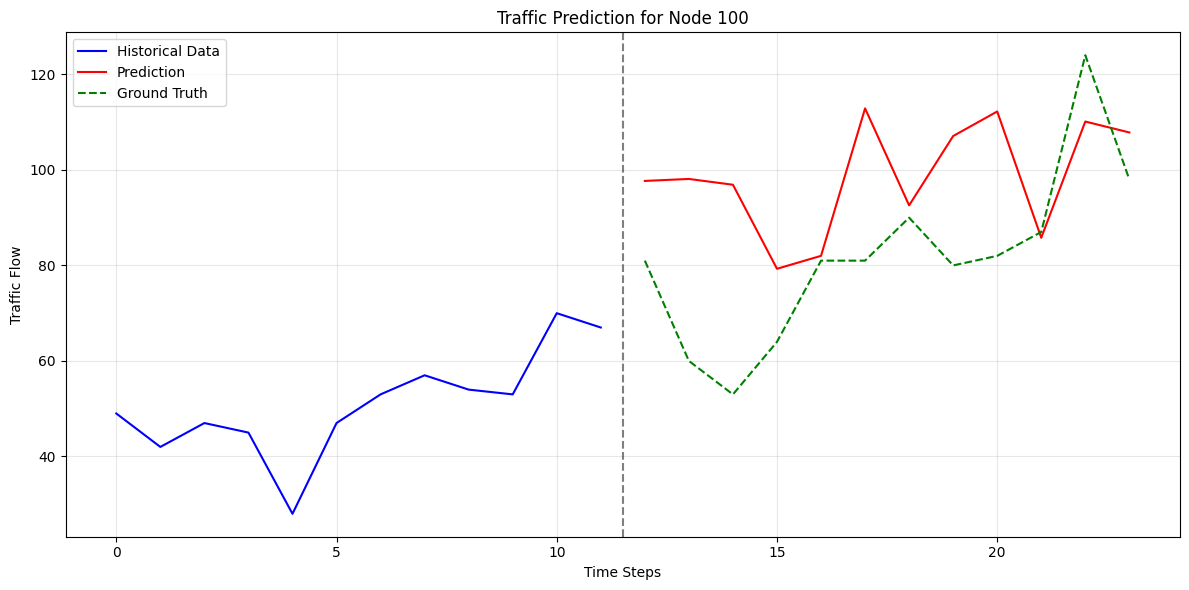

Node 100 - MAE: 19.3074, RMSE: 23.8976


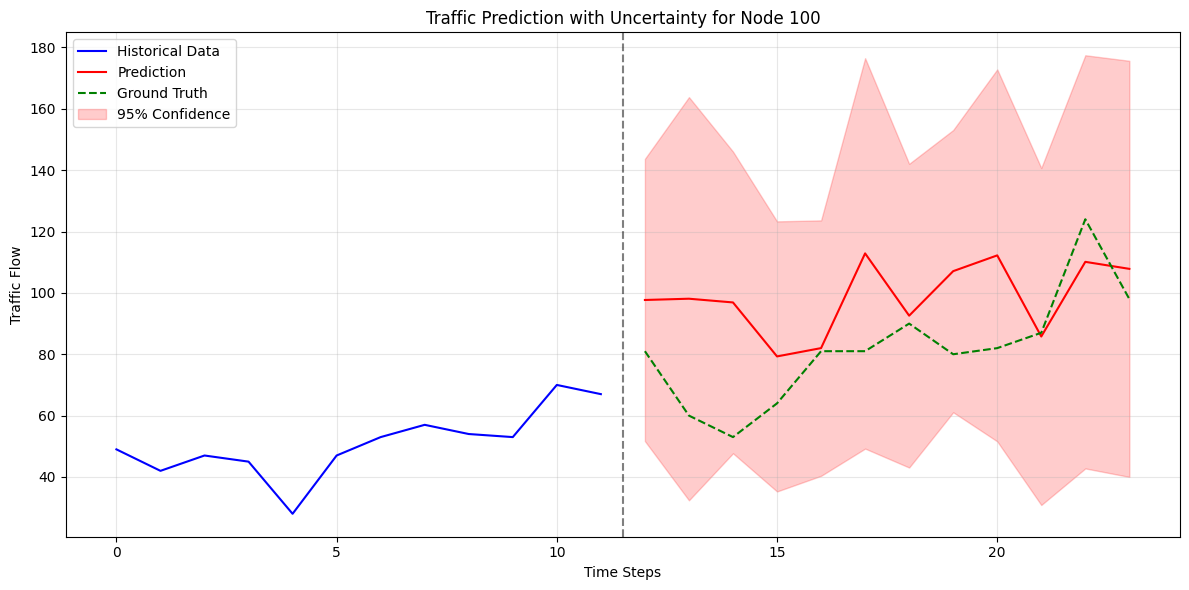

In [ ]:
# Select a specific node to visualize (0..307)
node_idx = 100  # node 100

# Get a batch of test data
x_batch, y_batch, _ = next(iter(te))
batch_idx = 0  # Select batch

# Make prediction
with torch.no_grad():
    mu, log_sigma = net(x_batch.cuda())

# Extract predictions and ground truth for the specified node
pred = mu[batch_idx, :, node_idx, :].cpu().numpy()  # Shape: [horizon, features]
true = y_batch[batch_idx, :, node_idx, :].numpy()   # Shape: [horizon, features]
hist = x_batch[batch_idx, :, node_idx, :].numpy()   # Shape: [window, features]

# Inverse transform to get original scale
# Use the scaler used during training
scaler = te.dataset.scaler
pred_original = scaler.inverse_transform(pred)
true_original = scaler.inverse_transform(true)
hist_original = scaler.inverse_transform(hist)

# Feature to visualize (0, 1, or 2 feature (flow, occupancy, or speed))
feature_idx = 0  

# Create time axis 
window_size = hist.shape[0]
horizon = pred.shape[0]
time_hist = np.arange(0, window_size)
time_pred = np.arange(window_size, window_size + horizon)
time_true = np.arange(window_size, window_size + horizon)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(time_hist, hist_original[:, feature_idx], 'b-', label='Historical Data')
plt.plot(time_pred, pred_original[:, feature_idx], 'r-', label='Prediction')
plt.plot(time_true, true_original[:, feature_idx], 'g--', label='Ground Truth')
plt.axvline(x=window_size-0.5, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Time Steps')
plt.ylabel('Traffic Flow')
plt.title(f'Traffic Prediction for Node {node_idx}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate error metrics for this node
mae = np.mean(np.abs(pred_original[:, feature_idx] - true_original[:, feature_idx]))
rmse = np.sqrt(np.mean((pred_original[:, feature_idx] - true_original[:, feature_idx])**2))
print(f"Node {node_idx} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# To analyze uncertainty, we can visualize the predicted standard deviation
std_dev = np.exp(log_sigma[batch_idx, :, node_idx, :].cpu().numpy() / 2)  # Convert log_sigma to standard deviation
std_dev_original = std_dev * scaler.scale_[feature_idx]  # Scale appropriately

# Plot with uncertainty
plt.figure(figsize=(12, 6))
plt.plot(time_hist, hist_original[:, feature_idx], 'b-', label='Historical Data')
plt.plot(time_pred, pred_original[:, feature_idx], 'r-', label='Prediction')
plt.plot(time_true, true_original[:, feature_idx], 'g--', label='Ground Truth')

# Add uncertainty band (mean ± 2*std_dev covers ~95% confidence interval)
plt.fill_between(time_pred,
                 pred_original[:, feature_idx] - 2*std_dev_original[:, feature_idx],
                 pred_original[:, feature_idx] + 2*std_dev_original[:, feature_idx],
                 color='r', alpha=0.2, label='95% Confidence')

plt.axvline(x=window_size-0.5, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Time Steps')
plt.ylabel('Traffic Flow')
plt.title(f'Traffic Prediction with Uncertainty for Node {node_idx}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

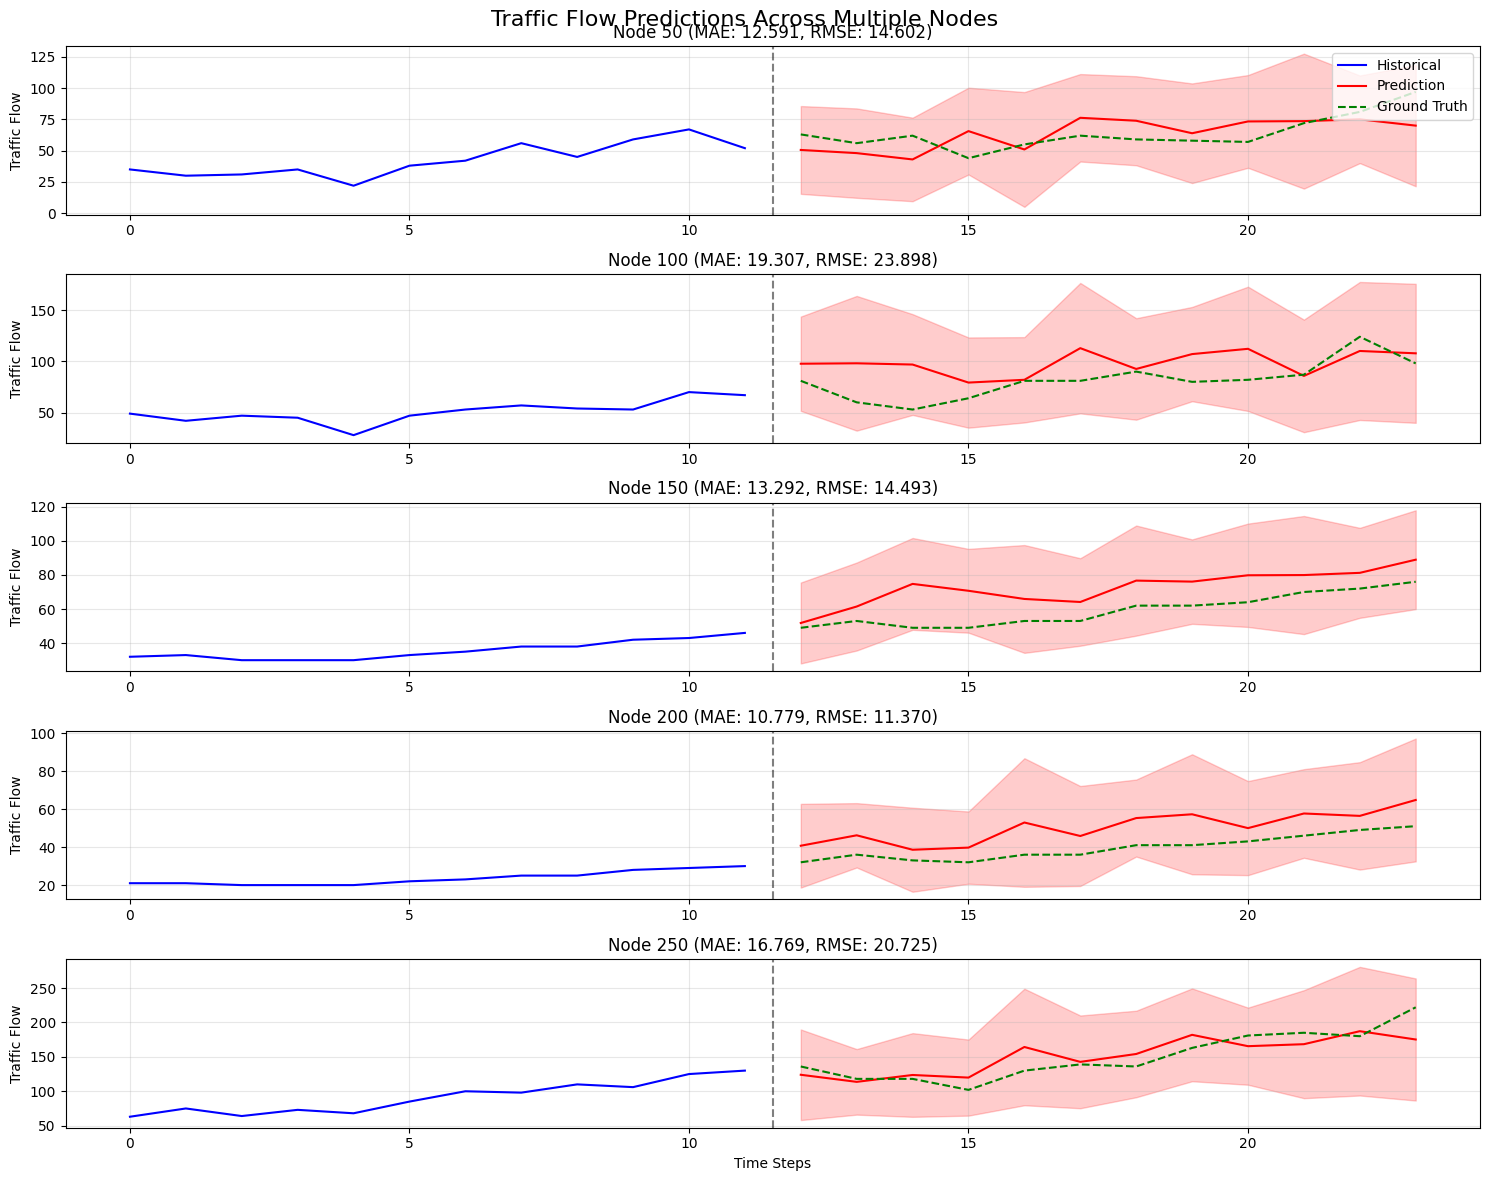

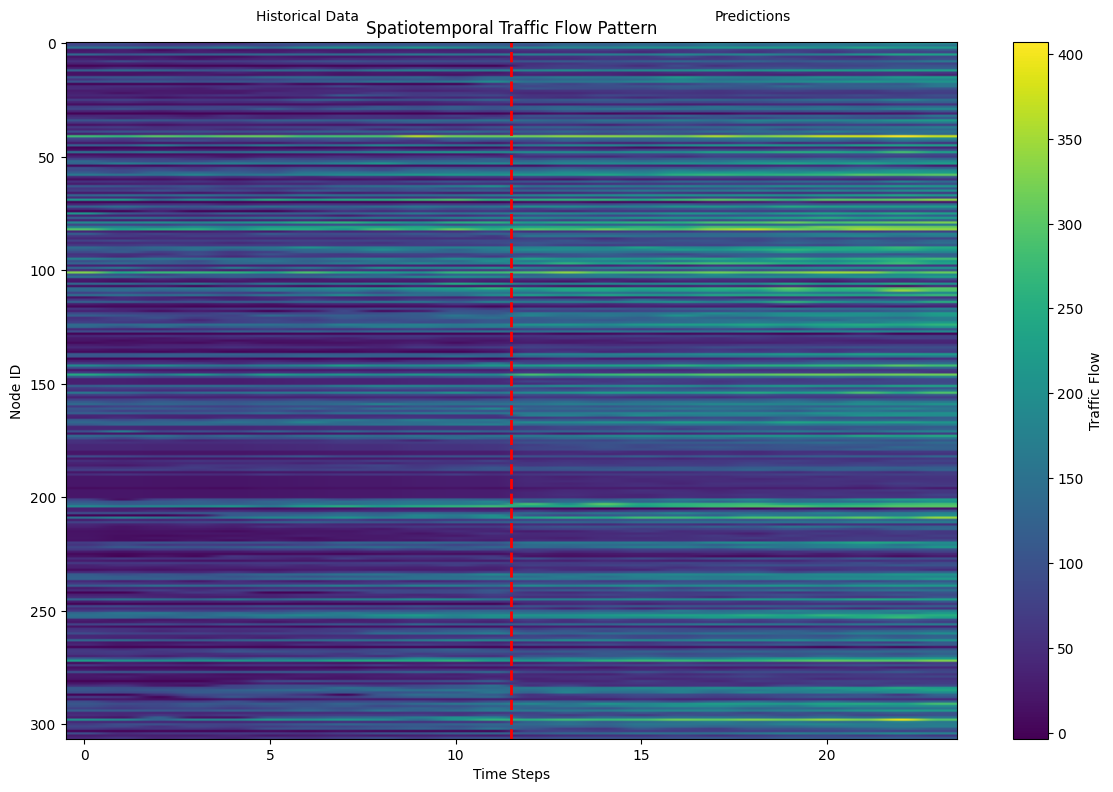

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Sample multiple nodes for comparison
node_indices = [50, 100, 150, 200, 250]  # Choose different nodes
feature_idx = 0  # First feature (traffic flow)

# Get a batch of test data
x_batch, y_batch, _ = next(iter(te))
batch_idx = 0  # First sample in batch

# Make prediction
with torch.no_grad():
    mu, log_sigma = net(x_batch.cuda())

# Set up the plot
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(len(node_indices), 1, figure=fig)
window_size = x_batch.shape[1]
horizon = y_batch.shape[1]

# Time axes
time_hist = np.arange(0, window_size)
time_future = np.arange(window_size, window_size + horizon)

# Plot each node
for i, node_idx in enumerate(node_indices):
    # Extract data for this node
    pred = mu[batch_idx, :, node_idx, feature_idx].cpu().numpy()
    true = y_batch[batch_idx, :, node_idx, feature_idx].numpy()
    hist = x_batch[batch_idx, :, node_idx, feature_idx].numpy()

    # Inverse transform if needed (using the dataset scaler)
    scaler = te.dataset.scaler
    scale_factor = scaler.scale_[feature_idx]
    mean_factor = scaler.mean_[feature_idx]

    pred_original = pred * scale_factor + mean_factor
    true_original = true * scale_factor + mean_factor
    hist_original = hist * scale_factor + mean_factor

    # Calculate uncertainty
    std_dev = np.exp(log_sigma[batch_idx, :, node_idx, feature_idx].cpu().numpy() / 2)
    std_dev_original = std_dev * scale_factor

    # Create subplot
    ax = fig.add_subplot(gs[i, 0])

    # Plot historical data, predictions and ground truth
    ax.plot(time_hist, hist_original, 'b-', label='Historical')
    ax.plot(time_future, pred_original, 'r-', label='Prediction')
    ax.plot(time_future, true_original, 'g--', label='Ground Truth')

    # Add uncertainty band
    ax.fill_between(time_future,
                   pred_original - 2*std_dev_original,
                   pred_original + 2*std_dev_original,
                   color='r', alpha=0.2)

    # Add vertical line separating historical data from predictions
    ax.axvline(x=window_size-0.5, color='k', linestyle='--', alpha=0.5)

    # Calculate error metrics
    mae = np.mean(np.abs(pred_original - true_original))
    rmse = np.sqrt(np.mean((pred_original - true_original)**2))

    # Formatting
    ax.set_title(f'Node {node_idx} (MAE: {mae:.3f}, RMSE: {rmse:.3f})')
    ax.grid(True, alpha=0.3)

    # Only add legend to the first plot to save space
    if i == 0:
        ax.legend(loc='upper right')

    # Only add x-label to the bottom plot
    if i == len(node_indices)-1:
        ax.set_xlabel('Time Steps')

    ax.set_ylabel('Traffic Flow')

plt.tight_layout()
plt.suptitle('Traffic Flow Predictions Across Multiple Nodes', fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

# You can also create a heatmap visualization of all nodes over time
def plot_traffic_heatmap():
    # Get a batch of test data
    x_batch, y_batch, _ = next(iter(te))
    batch_idx = 0  # First sample in batch

    # Make prediction for all nodes
    with torch.no_grad():
        mu, _ = net(x_batch.cuda())

    # Extract predictions and ground truth (for first feature)
    feature_idx = 0
    pred = mu[batch_idx, :, :, feature_idx].cpu().numpy()  # [horizon, nodes]
    true = y_batch[batch_idx, :, :, feature_idx].numpy()   # [horizon, nodes]
    hist = x_batch[batch_idx, :, :, feature_idx].numpy()   # [window, nodes]

    # Inverse transform to original scale
    scaler = te.dataset.scaler
    scale_factor = scaler.scale_[feature_idx]
    mean_factor = scaler.mean_[feature_idx]

    pred_original = pred * scale_factor + mean_factor
    true_original = true * scale_factor + mean_factor
    hist_original = hist * scale_factor + mean_factor

    # Combine historical and prediction data for visualization
    combined_data = np.vstack((hist_original, pred_original))

    # Create the heatmap
    plt.figure(figsize=(12, 8))
    plt.imshow(combined_data.T, aspect='auto', cmap='viridis')

    # Add a line separating historical data from predictions
    plt.axhline(y=-0.5, color='w', linestyle='-', alpha=0.8)
    plt.axvline(x=hist.shape[0]-0.5, color='r', linestyle='--', linewidth=2)

    # Add colorbar and labels
    plt.colorbar(label='Traffic Flow')
    plt.xlabel('Time Steps')
    plt.ylabel('Node ID')
    plt.title('Spatiotemporal Traffic Flow Pattern')

    # Add annotations
    plt.text(hist.shape[0]/2, -10, 'Historical Data', ha='center')
    plt.text(hist.shape[0] + pred.shape[0]/2, -10, 'Predictions', ha='center')

    plt.tight_layout()
    plt.show()

# Call the heatmap function
plot_traffic_heatmap()

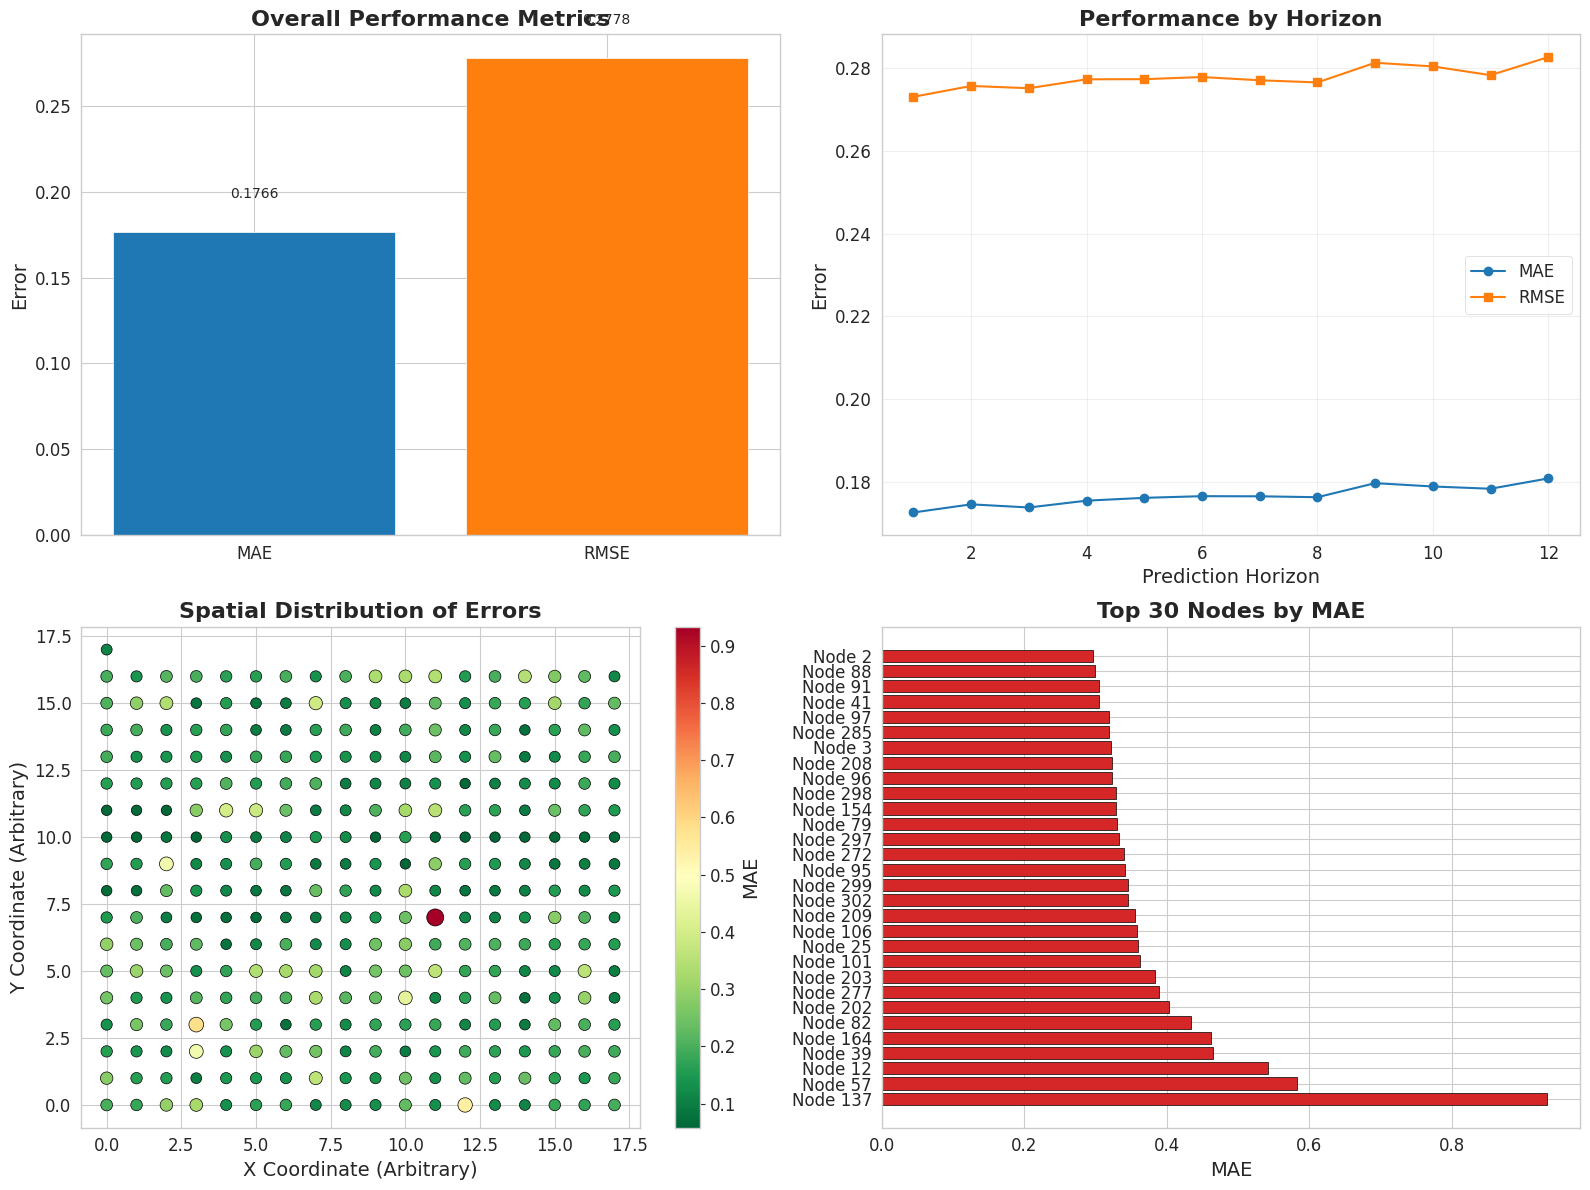

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set the style for all plots
plt.style.use('ggplot')
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 20

# Create a color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Visualization 1: Prediction Performance Across Time Horizons
def plot_horizon_performance():
    """Plot model performance across different prediction horizons"""
    # Get a batch of test data
    x_batch, y_batch, _ = next(iter(te))

    # Make predictions
    with torch.no_grad():
        mu, log_sigma = net(x_batch.cuda())

    # Calculate MAE and RMSE for each horizon
    feature_idx = 0  # First feature (traffic flow)
    mae_by_horizon = []
    rmse_by_horizon = []

    pred = mu.cpu().numpy()
    true = y_batch.numpy()

    # Inverse transform
    scaler = te.dataset.scaler
    scale_factor = scaler.scale_[feature_idx]
    mean_factor = scaler.mean_[feature_idx]

    for h in range(HOR):
        pred_h = pred[:, h, :, feature_idx] * scale_factor + mean_factor
        true_h = true[:, h, :, feature_idx] * scale_factor + mean_factor

        mae = mean_absolute_error(true_h.flatten(), pred_h.flatten())
        rmse = np.sqrt(mean_squared_error(true_h.flatten(), pred_h.flatten()))

        mae_by_horizon.append(mae)
        rmse_by_horizon.append(rmse)

    # Plot performance by horizon
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot MAE
    ax1.plot(range(1, HOR+1), mae_by_horizon, 'o-', color=colors[0], label='MAE')
    ax1.set_xlabel('Prediction Horizon (Time Steps)')
    ax1.set_ylabel('Mean Absolute Error', color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])

    # Create a second y-axis for RMSE
    ax2 = ax1.twinx()
    ax2.plot(range(1, HOR+1), rmse_by_horizon, 's-', color=colors[1], label='RMSE')
    ax2.set_ylabel('Root Mean Squared Error', color=colors[1])
    ax2.tick_params(axis='y', labelcolor=colors[1])

    # Add title and legend
    plt.title('Prediction Performance by Horizon', fontweight='bold')

    # Add combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

# Visualization 2: Weekly/Daily Traffic Pattern with Predictions
def plot_traffic_pattern_with_predictions():
    """Plot traffic patterns with predictions for a sample node"""
    # Choose a sample node
    node_idx = 100

    # Get a batch of test data
    x_batch, y_batch, _ = next(iter(te))
    batch_idx = 0

    # Make predictions
    with torch.no_grad():
        mu, log_sigma = net(x_batch.cuda())

    # Extract data for the selected node
    feature_idx = 0
    pred = mu[batch_idx, :, node_idx, feature_idx].cpu().numpy()
    true = y_batch[batch_idx, :, node_idx, feature_idx].numpy()
    hist = x_batch[batch_idx, :, node_idx, feature_idx].numpy()

    # Inverse transform
    scaler = te.dataset.scaler
    scale_factor = scaler.scale_[feature_idx]
    mean_factor = scaler.mean_[feature_idx]

    pred_original = pred * scale_factor + mean_factor
    true_original = true * scale_factor + mean_factor
    hist_original = hist * scale_factor + mean_factor

    # Calculate uncertainty
    std_dev = np.exp(log_sigma[batch_idx, :, node_idx, feature_idx].cpu().numpy() / 2)
    std_dev_original = std_dev * scale_factor

    # Assume 5-minute intervals (typical for PEMS data)
    # Create a fictional start time for visualization
    start_time = datetime(2025, 4, 27, 8, 0)  # 8 AM today
    time_points = [start_time + timedelta(minutes=5*i) for i in range(len(hist) + len(pred))]

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot historical data and predictions
    ax.plot(time_points[:len(hist)], hist_original, '-', color=colors[0], linewidth=2, label='Historical Data')
    ax.plot(time_points[len(hist):], pred_original, '-', color=colors[1], linewidth=2, label='Prediction')
    ax.plot(time_points[len(hist):], true_original, '--', color=colors[2], linewidth=2, label='Ground Truth')

    # Add uncertainty bands
    ax.fill_between(time_points[len(hist):],
                   pred_original - 2*std_dev_original,
                   pred_original + 2*std_dev_original,
                   color=colors[1], alpha=0.2, label='95% Confidence Interval')

    # Add vertical line separating historical from prediction
    ax.axvline(x=time_points[len(hist)-1], color='black', linestyle='--', alpha=0.7)

    # Format x-axis to show time
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gcf().autofmt_xdate()

    # Add labels and title
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Traffic Flow')
    ax.set_title(f'Traffic Flow Prediction for Sensor Node {node_idx}', fontweight='bold')

    # Add text annotations
    ax.text(time_points[len(hist)//2], max(hist_original)*1.05, 'Historical Data',
            ha='center', va='bottom', fontsize=12, color=colors[0])
    ax.text(time_points[len(hist) + len(pred)//2], max(hist_original)*1.05, 'Prediction',
            ha='center', va='bottom', fontsize=12, color=colors[1])

    # Add legend
    ax.legend(loc='upper right')

    plt.tight_layout()
    return fig

# Visualization 3: Spatial Heatmap with Temporal Animation
def create_spatiotemporal_heatmap():
    """Create a composite visualization showing spatial patterns over time"""
    # Get a batch of test data
    x_batch, y_batch, _ = next(iter(te))
    batch_idx = 0

    # Make predictions
    with torch.no_grad():
        mu, _ = net(x_batch.cuda())

    # Extract predictions and ground truth
    feature_idx = 0
    pred = mu[batch_idx, :, :, feature_idx].cpu().numpy()  # [horizon, nodes]
    true = y_batch[batch_idx, :, :, feature_idx].numpy()   # [horizon, nodes]
    hist = x_batch[batch_idx, :, :, feature_idx].numpy()   # [window, nodes]

    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, height_ratios=[1, 1.5], width_ratios=[3, 1])

    # Create a custom colormap
    cmap = plt.cm.viridis

    # 1. Main spatiotemporal heatmap (full dataset)
    ax1 = fig.add_subplot(gs[0, :])
    combined_data = np.vstack((hist, pred))
    im = ax1.imshow(combined_data.T, aspect='auto', cmap=cmap)

    # Add a vertical line separating history from prediction
    ax1.axvline(x=hist.shape[0]-0.5, color='red', linestyle='--', linewidth=2)

    # Add labels
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Sensor Nodes')
    ax1.set_title('Spatiotemporal Traffic Pattern', fontweight='bold')

    # Add text annotations
    ax1.text(hist.shape[0]/2, -10, 'Historical Data', ha='center')
    ax1.text(hist.shape[0] + pred.shape[0]/2, -10, 'Predictions', ha='center')

    # Add colorbar
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(im, cax=cax1, label='Traffic Flow (Normalized)')

    # 2. Temporal cross-section (average over all nodes)
    ax2 = fig.add_subplot(gs[1, 0])

    # Calculate average traffic over all nodes
    avg_hist = np.mean(hist, axis=1)
    avg_pred = np.mean(pred, axis=1)
    avg_true = np.mean(true, axis=1)

    # Generate time points
    time_points = np.arange(len(avg_hist) + len(avg_pred))

    # Plot the average traffic
    ax2.plot(time_points[:len(avg_hist)], avg_hist, '-', color=colors[0], linewidth=2, label='Historical (Avg)')
    ax2.plot(time_points[len(avg_hist):], avg_pred, '-', color=colors[1], linewidth=2, label='Prediction (Avg)')
    ax2.plot(time_points[len(avg_hist):], avg_true, '--', color=colors[2], linewidth=2, label='Ground Truth (Avg)')

    # Add vertical line
    ax2.axvline(x=len(avg_hist)-0.5, color='red', linestyle='--', linewidth=2)

    # Add labels and legend
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Average Traffic Flow')
    ax2.set_title('Average Traffic Over All Sensors', fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # 3. Spatial cross-section (traffic distribution across nodes)
    ax3 = fig.add_subplot(gs[1, 1])

    # Select a specific time step for prediction
    pred_time_idx = 5  # Mid-prediction horizon

    # Calculate node distribution at the selected time
    hist_dist = np.mean(hist, axis=0)  # Average historical traffic for each node
    pred_dist = pred[pred_time_idx]    # Predicted traffic at the selected time

    # Sort nodes by historical average traffic
    sort_idx = np.argsort(hist_dist)

    # Number of nodes to show (to avoid overcrowding)
    n_nodes = 30
    step = len(sort_idx) // n_nodes
    selected_nodes = sort_idx[::step][:n_nodes]

    # Create horizontal bar chart
    y_pos = np.arange(len(selected_nodes))
    ax3.barh(y_pos, hist_dist[selected_nodes], height=0.4, color=colors[0], alpha=0.7, label='Historical Avg')
    ax3.barh(y_pos + 0.4, pred_dist[selected_nodes], height=0.4, color=colors[1], alpha=0.7, label='Prediction')

    # Add labels and legend
    ax3.set_yticks(y_pos + 0.2)
    ax3.set_yticklabels([f'Node {i}' for i in selected_nodes])
    ax3.set_xlabel('Traffic Flow')
    ax3.set_title('Distribution Across Nodes', fontweight='bold')
    ax3.legend(loc='upper right')

    plt.tight_layout()
    return fig

# Visualization 4: Error Analysis and Model Uncertainty
def plot_error_analysis():
    """Create visualizations for error analysis and model uncertainty"""
    # Get a batch of test data
    x_batch, y_batch, _ = next(iter(te))

    # Make predictions
    with torch.no_grad():
        mu, log_sigma = net(x_batch.cuda())

    # Extract predictions and ground truth
    feature_idx = 0
    pred = mu[:, :, :, feature_idx].cpu().numpy()  # [batch, horizon, nodes]
    true = y_batch[:, :, :, feature_idx].numpy()   # [batch, horizon, nodes]

    # Reshape for analysis
    pred_flat = pred.reshape(-1)
    true_flat = true.reshape(-1)

    # Calculate uncertainty (standard deviation)
    std_dev = np.exp(log_sigma[:, :, :, feature_idx].cpu().numpy() / 2)
    std_dev_flat = std_dev.reshape(-1)

    # Calculate errors
    errors = pred_flat - true_flat
    abs_errors = np.abs(errors)

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(2, 2)

    # 1. Scatter plot of predicted vs actual values
    ax1 = fig.add_subplot(gs[0, 0])
    scatter = ax1.scatter(true_flat, pred_flat, c=std_dev_flat, cmap='viridis',
                         alpha=0.5, s=10, edgecolors='none')

    # Add perfect prediction line
    min_val, max_val = min(np.min(true_flat), np.min(pred_flat)), max(np.max(true_flat), np.max(pred_flat))
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    # Add labels and title
    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title('Prediction Performance', fontweight='bold')

    # Add colorbar for uncertainty
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Uncertainty (Std Dev)')

    # 2. Error histogram
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.hist(errors, bins=50, color=colors[0], alpha=0.7, edgecolor='black', linewidth=0.5)

    # Add vertical line at zero
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)

    # Add labels and title
    ax2.set_xlabel('Prediction Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Error Distribution', fontweight='bold')

    # Add mean and std annotations
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    ax2.text(0.05, 0.95, f'Mean Error: {mean_error:.4f}\nStd Dev: {std_error:.4f}',
             transform=ax2.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # 3. Uncertainty vs Error Magnitude
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.scatter(std_dev_flat, abs_errors, alpha=0.5, s=10, color=colors[2], edgecolors='none')

    # Add labels and title
    ax3.set_xlabel('Model Uncertainty (Std Dev)')
    ax3.set_ylabel('Absolute Error')
    ax3.set_title('Uncertainty vs Error Magnitude', fontweight='bold')

    # Add trend line
    z = np.polyfit(std_dev_flat, abs_errors, 1)
    p = np.poly1d(z)
    ax3.plot(np.sort(std_dev_flat), p(np.sort(std_dev_flat)), 'r--', linewidth=2)

    # Calculate correlation
    corr = np.corrcoef(std_dev_flat, abs_errors)[0, 1]
    ax3.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=ax3.transAxes,
             va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # 4. Prediction Calibration Plot
    ax4 = fig.add_subplot(gs[1, 1])

    # Calculate error standardized by predicted uncertainty
    z_scores = errors / std_dev_flat

    # Create Q-Q plot comparing z-scores to standard normal
    from scipy import stats
    stats.probplot(z_scores, dist="norm", plot=ax4)

    # Add labels and title
    ax4.set_title('Prediction Calibration (Q-Q Plot)', fontweight='bold')

    plt.tight_layout()
    return fig

# Visualization 5: Attention Weights Analysis
def visualize_attention_weights():
    """Visualize and analyze the attention weights"""
    # Get a batch of test data
    x, _, _ = next(iter(te))

    # Extract attention weights from the model
    with torch.no_grad():
        # Get the last attention block
        blk = net.enc[-1].attn

        # Forward pass through the embedding layer
        h = net.inp(x.cuda()) + net.spa[None, None] + net.temb(torch.arange(WIN, device='cuda')[None, :])[..., None, :]
        h = h.contiguous().view(-1, N, 64)

        # Extract query and key values
        q, k, v = blk.qkv(h).view(h.size(0), N, 3, blk.h, blk.dk).unbind(2)

        # Apply phi function
        q, k = map(blk.phi, (q, k))

        # Compute attention weights for the first batch element and first head
        attention_weights = []
        for i in range(h.size(0)):
            # Compute attention matrix for this timestep
            A = (q[i, :, 0] @ k[i, :, 0].T).cpu().numpy()
            attention_weights.append(A)

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(2, 3)

    # 1. Attention heatmap for the last time step
    ax1 = fig.add_subplot(gs[0, 0])
    last_step_attn = attention_weights[-1]
    im1 = ax1.imshow(last_step_attn, aspect='auto', cmap='viridis')

    # Add labels and title
    ax1.set_xlabel('Node (Key)')
    ax1.set_ylabel('Node (Query)')
    ax1.set_title('Attention Weights at Last Time Step', fontweight='bold')

    # Add colorbar
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)

    # 2. Evolution of attention pattern over time
    ax2 = fig.add_subplot(gs[0, 1:])

    # Select a specific node to track
    node_idx = 100

    # Extract attention weights for the selected node over time
    node_attn_over_time = np.array([attn[node_idx, :] for attn in attention_weights])

    # Plot as a heatmap
    im2 = ax2.imshow(node_attn_over_time, aspect='auto', cmap='viridis')

    # Add labels and title
    ax2.set_xlabel('Target Node')
    ax2.set_ylabel('Time Step')
    ax2.set_title(f'Attention Evolution for Node {node_idx}', fontweight='bold')

    # Add colorbar
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(im2, cax=cax2)

    # 3. Attention pattern analysis
    ax3 = fig.add_subplot(gs[1, 0])

    # Calculate average attention to self vs others
    self_attention = np.array([attn[i, i] for i in range(N) for attn in attention_weights])

    # Calculate average attention to other nodes
    other_attention = []
    for attn in attention_weights:
        for i in range(N):
            other_attention.extend(attn[i, :][np.arange(N) != i])

    # Create box plot
    box_data = [self_attention, other_attention]
    ax3.boxplot(box_data, labels=['Self-Attention', 'Cross-Attention'])

    # Add labels and title
    ax3.set_ylabel('Attention Weight')
    ax3.set_title('Self vs Cross Attention Distribution', fontweight='bold')

    # 4. Top attention connections
    ax4 = fig.add_subplot(gs[1, 1])

    # Calculate average attention matrix across all time steps
    avg_attn = np.mean(attention_weights, axis=0)

    # Flatten and get top connections (excluding self-attention)
    np.fill_diagonal(avg_attn, 0)  # Zero out self-attention
    flat_attn = avg_attn.flatten()
    top_indices = np.argsort(flat_attn)[-20:]  # Top 20 connections

    # Convert flat indices to node pairs
    top_pairs = [(idx // N, idx % N) for idx in top_indices]
    top_values = [flat_attn[idx] for idx in top_indices]

    # Create horizontal bar chart
    y_pos = np.arange(len(top_pairs))
    ax4.barh(y_pos, top_values, color=colors[4])

    # Add labels
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels([f'({src}, {tgt})' for src, tgt in top_pairs])
    ax4.set_xlabel('Attention Weight')
    ax4.set_title('Top Cross-Attention Connections', fontweight='bold')

    # 5. Attention vs Distance
    ax5 = fig.add_subplot(gs[1, 2])

    # Create a synthetic spatial distance matrix (for illustration)
    # In a real scenario, you would use actual geographical distances between sensors
    # Here we'll create a simple proxy based on node indices
    distances = np.abs(np.arange(N)[:, None] - np.arange(N)[None, :])

    # Flatten attention weights and distances (excluding self-attention)
    mask = ~np.eye(N, dtype=bool)
    flat_attn = avg_attn[mask]
    flat_dist = distances[mask]

    # Plot as scatter
    ax5.scatter(flat_dist, flat_attn, alpha=0.1, s=5, color=colors[5])

    # Add labels and title
    ax5.set_xlabel('Node Distance (Index Difference)')
    ax5.set_ylabel('Average Attention Weight')
    ax5.set_title('Attention vs Distance', fontweight='bold')

    # Add trend line
    z = np.polyfit(flat_dist, flat_attn, 1)
    p = np.poly1d(z)
    ax5.plot(np.sort(flat_dist), p(np.sort(flat_dist)), 'r--', linewidth=2)

    plt.tight_layout()
    return fig

# Visualization 6: Model Performance Dashboard
def create_model_dashboard():
    """Create a comprehensive dashboard of model performance"""
    # Get all test data
    all_preds = []
    all_true = []

    # Iterate through test dataloader
    for x, y, _ in te:
        with torch.no_grad():
            mu, _ = net(x.cuda())

        all_preds.append(mu.cpu().numpy())
        all_true.append(y.numpy())

    # Concatenate results
    all_preds = np.concatenate(all_preds, axis=0)
    all_true = np.concatenate(all_true, axis=0)

    # Calculate metrics for all horizons and features
    feature_idx = 0

    # Overall metrics
    mae_all = np.mean(np.abs(all_preds[:, :, :, feature_idx] - all_true[:, :, :, feature_idx]))
    rmse_all = np.sqrt(np.mean((all_preds[:, :, :, feature_idx] - all_true[:, :, :, feature_idx])**2))

    # Metrics by horizon
    mae_by_horizon = []
    rmse_by_horizon = []

    for h in range(HOR):
        mae_h = np.mean(np.abs(all_preds[:, h, :, feature_idx] - all_true[:, h, :, feature_idx]))
        rmse_h = np.sqrt(np.mean((all_preds[:, h, :, feature_idx] - all_true[:, h, :, feature_idx])**2))

        mae_by_horizon.append(mae_h)
        rmse_by_horizon.append(rmse_h)

    # Metrics by node
    mae_by_node = np.mean(np.abs(all_preds[:, :, :, feature_idx] - all_true[:, :, :, feature_idx]), axis=(0, 1))
    rmse_by_node = np.sqrt(np.mean((all_preds[:, :, :, feature_idx] - all_true[:, :, :, feature_idx])**2, axis=(0, 1)))

    # Create dashboard
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 2)

    # 1. Overall performance metrics
    ax1 = fig.add_subplot(gs[0, 0])
    metrics = ['MAE', 'RMSE']
    values = [mae_all, rmse_all]

    ax1.bar(metrics, values, color=[colors[0], colors[1]])

    # Add values on top of bars
    for i, v in enumerate(values):
        ax1.text(i, v + 0.02, f'{v:.4f}', ha='center')

    # Add labels and title
    ax1.set_ylabel('Error')
    ax1.set_title('Overall Performance Metrics', fontweight='bold')

    # 2. Performance by horizon
    ax2 = fig.add_subplot(gs[0, 1])
    x = np.arange(1, HOR + 1)

    # Plot MAE and RMSE by horizon
    ax2.plot(x, mae_by_horizon, 'o-', color=colors[0], label='MAE')
    ax2.plot(x, rmse_by_horizon, 's-', color=colors[1], label='RMSE')

    # Add labels and title
    ax2.set_xlabel('Prediction Horizon')
    ax2.set_ylabel('Error')
    ax2.set_title('Performance by Horizon', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Spatial distribution of errors
    ax3 = fig.add_subplot(gs[1, 0])

    # Assume nodes have some spatial arrangement
    # We'll create a simplified version for visualization
    # In real scenarios, you would use actual geographical coordinates

    # Create a grid layout for nodes
    grid_size = int(np.ceil(np.sqrt(N)))
    node_pos_x = np.tile(np.arange(grid_size), grid_size)[:N]
    node_pos_y = np.repeat(np.arange(grid_size), grid_size)[:N]

    # Plot nodes as scatter with size/color indicating error
    scatter = ax3.scatter(node_pos_x, node_pos_y, c=mae_by_node, s=50+100*mae_by_node/mae_by_node.max(),
                         cmap='RdYlGn_r', edgecolors='black', linewidth=0.5)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('MAE')

    # Add labels and title
    ax3.set_xlabel('X Coordinate (Arbitrary)')
    ax3.set_ylabel('Y Coordinate (Arbitrary)')
    ax3.set_title('Spatial Distribution of Errors', fontweight='bold')

    # 4. Error distribution across nodes
    ax4 = fig.add_subplot(gs[1, 1])

    # Select a subset of nodes for visualization (highest-error)
    num_nodes_to_show = 30
    nodes_to_show = np.argsort(mae_by_node)[-num_nodes_to_show:]

    # Plot horizontal bar chart of MAE by node
    sorted_mae = mae_by_node[nodes_to_show]
    node_labels = [f'Node {i}' for i in nodes_to_show]

    y_pos = np.arange(len(nodes_to_show))
    ax4.barh(y_pos, sorted_mae, color=colors[3], edgecolor='black')

    # Add labels and title
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(node_labels)
    ax4.invert_yaxis()  # highest error at top
    ax4.set_xlabel('MAE')
    ax4.set_title(f'Top {num_nodes_to_show} Nodes by MAE', fontweight='bold')

    plt.tight_layout()
    return fig

fig6 = create_model_dashboard()
fig6.show()